In [1]:
%load_ext autoreload
%autoreload 2

# Training Custom ResNet on FastAI Imagenette

In [2]:
from importlib.util import find_spec
if find_spec("model") is None:
    import sys
    sys.path.append('..')

In [3]:
from model.backbone.resnet import ResNet50

## Build DataLoaders

Following [Fast AI Tutorial](https://docs.fast.ai/tutorial.imagenette)

In [4]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [5]:
path = untar_data(URLs.IMAGENETTE)

### Using FastAI Factory Method to Load Dataset

In [5]:
dls = ImageDataLoaders.from_folder(path, valid='val',
                                   item_tfms=RandomResizedCrop(128, min_scale=0.35),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                                  )

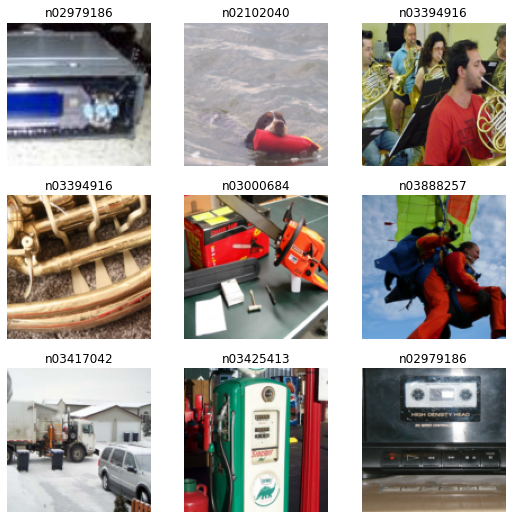

In [6]:
dls.show_batch()

### Using FastAI Data Block API to Load Dataset

In [7]:
fnames = get_image_files(path)

In [8]:
dblock = DataBlock()

In [9]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/home/kmh/.fastai/data/imagenette2/train/n03445777/n03445777_755.JPEG'),
 Path('/home/kmh/.fastai/data/imagenette2/train/n03445777/n03445777_755.JPEG'))

In [10]:
dblock = DataBlock(get_items = get_image_files)

In [11]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/kmh/.fastai/data/imagenette2/train/n03000684/n03000684_17587.JPEG'),
 Path('/home/kmh/.fastai/data/imagenette2/train/n03000684/n03000684_17587.JPEG'))

In [12]:
parent_label(fnames[0])

'n02102040'

In [5]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [6]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(),
    item_tfms=RandomResizedCrop(128, min_scale=0.35),
    batch_tfms=Normalize.from_stats(*imagenet_stats)
    )
dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=500x375, TensorCategory(0))

In [16]:
dsets.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

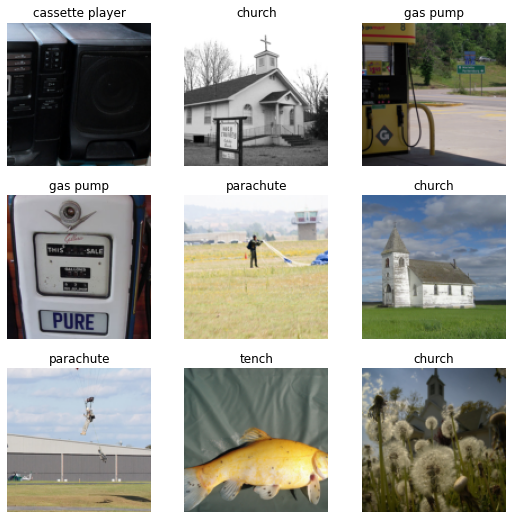

In [17]:
dls = dblock.dataloaders(path)
dls.show_batch()

## Using FastAPI's Mid-Level API to Load the Data

In [7]:
source = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(source)

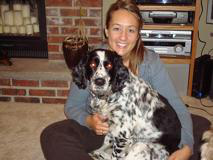

In [8]:
PILImage.create(fnames[0])

In [9]:
lbl_dict[parent_label(fnames[0])]

'English springer'

In [10]:
tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab=lbl_dict.values())])
tfm(fnames[0])

TensorCategory(0)

In [11]:
splits = GrandparentSplitter(valid_name='val')(fnames)

In [12]:
dsets = Datasets(fnames, [[PILImage.create], tfm], splits=splits)

In [13]:
dsets[0]

(PILImage mode=RGB size=213x160, TensorCategory(0))

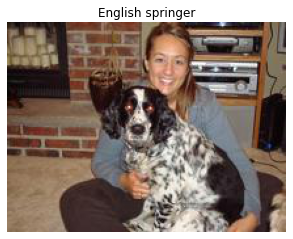

In [14]:
dsets.show(dsets[0]);

In [15]:
item_tfms = [ToTensor, RandomResizedCrop(224, min_scale=0.35)]

In [16]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]

In [17]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=1)

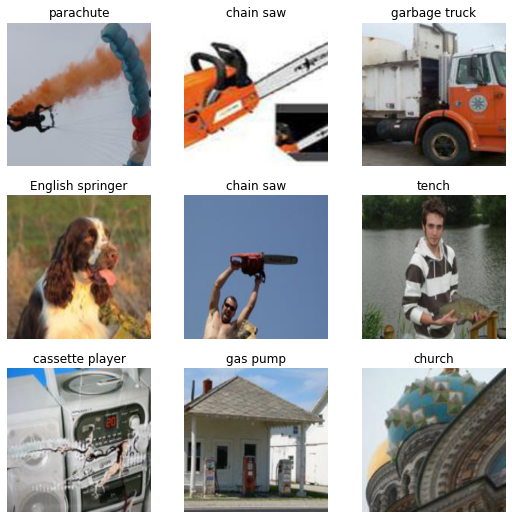

In [19]:
dls.show_batch()

## Training The Model

Using FastAI's Own ResNet Model As Baseline.

In [30]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.001737800776027143)

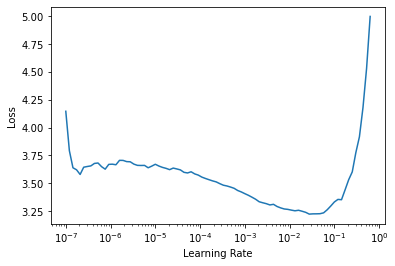

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.583020,2.350806,0.311083,00:31
1,1.932188,2.203403,0.394395,00:32
2,1.618565,1.836344,0.404331,00:31
3,1.324143,1.317288,0.605860,00:32
4,1.144473,1.018897,0.687134,00:32


In [33]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0006918309954926372)

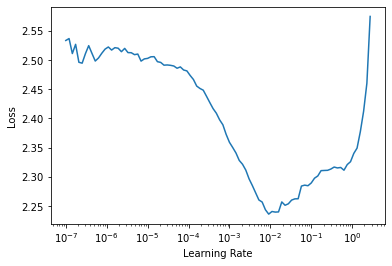

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.828153,1.644653,0.461656,00:35
1,1.337268,1.206478,0.614522,00:35
2,1.066167,1.061462,0.662675,00:35
3,0.891281,0.876011,0.728153,00:35
4,0.797870,0.837476,0.740382,00:35


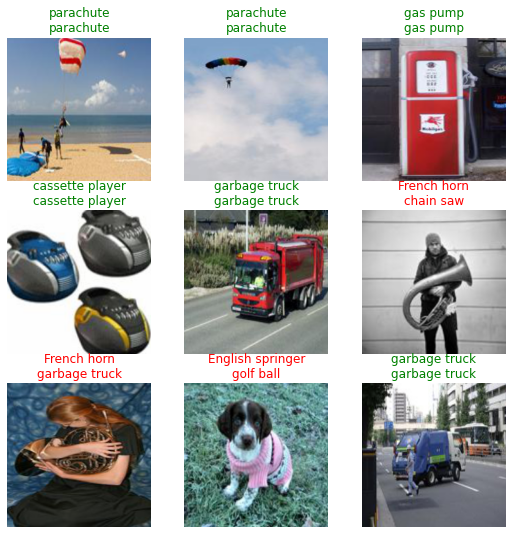

In [36]:
learn.show_results()

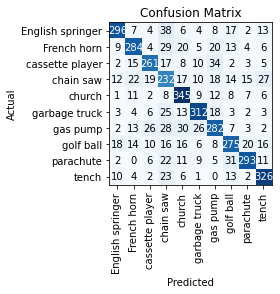

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title="Confusion Matrix")

Using own model with Xavier Normal Init for Linear Layer

In [18]:
learn = Learner(dls, ResNet50(num_classes=10), metrics=accuracy, pretrained=False)

../model/backbone/resnet.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=1.5848932266235352)

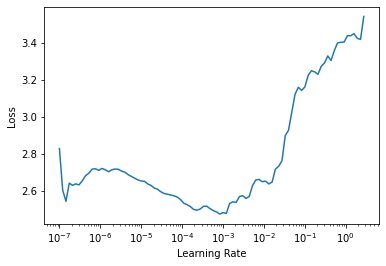

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(4, 3e-6)

epoch,train_loss,valid_loss,accuracy,time
0,2.399457,2.292421,0.152357,01:00
1,2.159214,2.139052,0.250446,01:00
2,2.085779,2.091097,0.276178,01:01
3,2.065543,2.071860,0.294522,01:01


../model/backbone/resnet.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=0.5248074531555176)

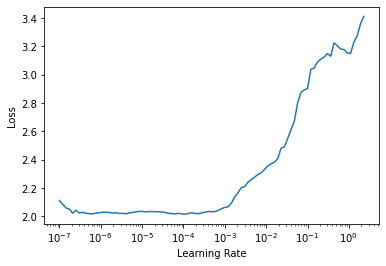

In [21]:
learn.lr_find()

Using own model with Normal Init (std=0.01) for Linear Layer

In [18]:
learn = Learner(dls, ResNet50(num_classes=10), metrics=accuracy, pretrained=False)

../model/backbone/resnet.py:108: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=1.3182567358016968)

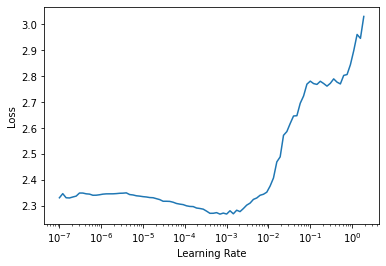

In [19]:
learn.lr_find()

In [ ]:

learn.fit_one_cycle(4, 3e-6)

Using PyTorch ResNet Inits.

In [19]:
learn = Learner(dls, ResNet50(num_classes=10), loss_func=F.nll_loss, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=0.2089296132326126)

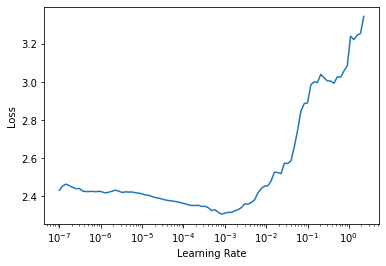

In [20]:
learn.lr_find()

Using FastAI XResNet Init.

In [18]:
learn = Learner(dls, ResNet50(num_classes=10), loss_func=F.nll_loss, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=6.30957365501672e-05)

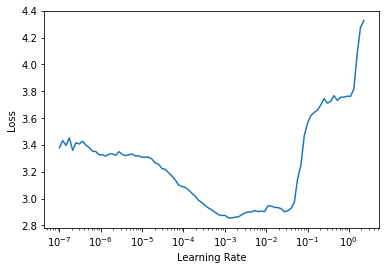

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.041634,3.046450,0.230064,01:01
1,1.592707,1.743295,0.461911,01:01
2,1.225930,1.161230,0.629554,01:01
3,0.955589,0.952006,0.696561,01:01


## Change Loss

In [17]:
learn = Learner(dls, ResNet50(num_classes=10), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=1.0964781722577754e-06)

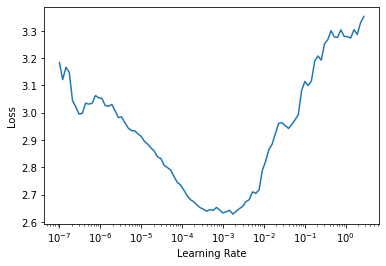

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(4, 5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.064080,2.210965,0.267261,01:01
1,1.740829,1.729175,0.424968,01:01
2,1.570419,1.540969,0.492229,01:01
3,1.476536,1.502677,0.501911,01:01


SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=0.25118863582611084)

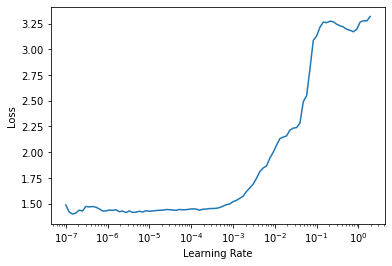

In [20]:
learn.lr_find()

In [20]:
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.1, reduction="mean"):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        
        if self.reduction == "sum":
            loss = -log_preds.sum()
        
        else:
            loss = -log_preds.sum(dim=-1)
            
            if self.reduction == "mean":
                loss = loss.mean()
            
        return loss * self.eps / c + (1 - self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)
    
    def activation(self, out): 
        return F.softmax(out, dim=-1)
    def decodes(self, out):
        return out.argmax(dim=-1)


In [18]:
learn = Learner(dls, ResNet50(num_classes=10), loss_func=LabelSmoothingCE(), metric=accuracy)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=4.365158383734524e-05)

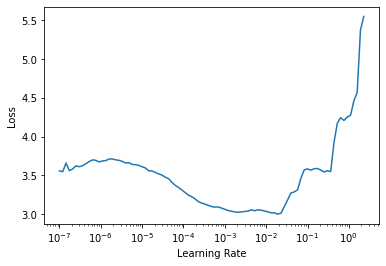

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(4, 4e-5)

epoch,train_loss,valid_loss,time
0,2.208733,2.221784,01:01
1,1.884478,1.896363,01:01
2,1.758430,1.784263,01:01
3,1.698823,1.718860,01:01


## Changing The Optimizer

In [21]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(param_groups, **kwargs):
    return OptimWrapper(torch.optim.AdamW([{'params': ps, **kwargs} for ps in param_groups]))

In [19]:
learn = Learner(dls, 
                ResNet50(num_classes=10), 
                lr=1e-2, metric=accuracy, 
                loss_func=LabelSmoothingCrossEntropy(), 
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3)
               )

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=0.9120108485221863)

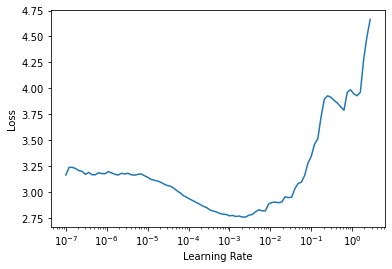

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,time
0,2.132716,2.812843,01:01
1,1.760007,1.799982,01:01
2,1.482069,1.483695,01:02
3,1.339877,1.361853,01:02


## Adding Callbacks

In [19]:
from torch.distributions.beta import Beta

In [20]:
class Mixup(Callback):
    run_valid = False
    
    def __init__(self, alpha=0.4):
        self.distribution = Beta(tensor(alpha), tensor(alpha))
        
    def before_batch(self):
        self.t = self.distribution.sample((self.y.size(0), )).squeeze().to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        x1, self.y1 = self.x[shuffle], self.y[shuffle]
        self.learn.xb = (x1 * (1-self.t[:, None, None, None]) + self.x * self.t[:, None, None, None],)
        
    def after_loss(self):
        with NoneReduce(self.loss_func) as lf:
            loss = lf(self.pred, self.y1) * (1 - self.t) + lf(self.pred, self.y)  * self.t
            
        self.learn.loss = loss.mean()

In [21]:
learn = Learner(dls, 
                ResNet50(num_classes=10), 
                lr=1e-2, metric=accuracy, 
                loss_func=LabelSmoothingCrossEntropy(), 
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3),
                cbs=Mixup()
               )

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.3630780577659607)

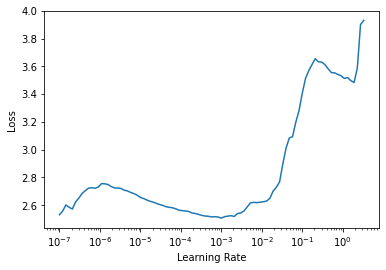

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,time
0,2.297717,4.291862,01:01
1,2.033022,1.886503,01:01
2,1.825186,1.611014,01:02
3,1.722684,1.511372,01:02


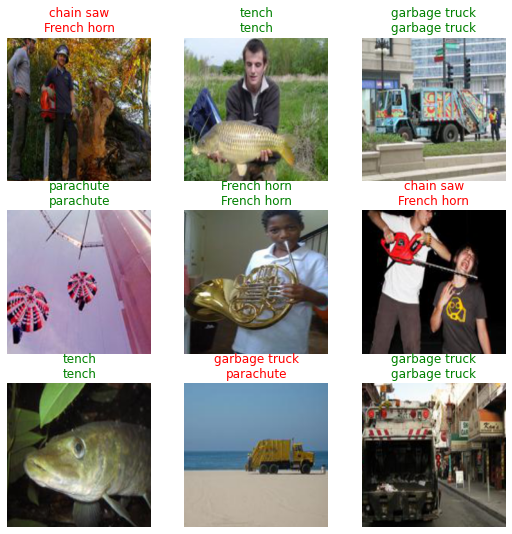

In [25]:
learn.show_results()

Re-enable Detectron Init.

In [ ]:
learn = Learner(dls, ResNet50(num_classes=10), loss_func=CrossEntropyLossFlat(), metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=0.0003311311302240938)

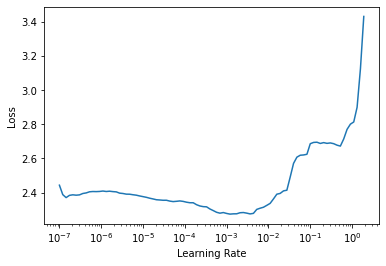

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.852943,2.341852,0.316178,01:00
1,1.454160,1.745871,0.436943,01:01
2,1.129525,1.293205,0.592102,01:01
3,0.910110,0.867529,0.725350,01:01


## Testing XResNet

In [18]:
from model.backbone.xresnet import XResNet, RESNET50_LAYERS

In [19]:
model_50 = XResNet(RESNET50_LAYERS, out_features=[], num_classes=10)

In [20]:
learn = Learner(dls, model_50, loss_func=CrossEntropyLossFlat(), metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0006918309954926372)

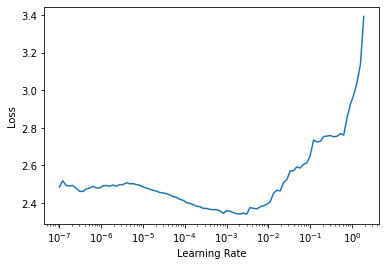

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(4, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.929959,2.024546,0.380637,01:00
1,1.528000,1.528094,0.543949,01:00
2,1.147218,1.233447,0.622420,01:01
3,0.901748,0.909495,0.705478,01:01
